In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
print(torch.cuda.get_device_name)

<function get_device_name at 0x79117e5ba8c0>


# **Dataset, transforms, and Visualisation**

In [ ]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True,  download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform_test)

100%|██████████| 170498071/170498071 [00:14<00:00, 11897886.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
iterator = iter(trainloader)
data, labels = next(iterator)
print(data.shape, labels.shape)

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [ ]:
def imshow(fig, title):
    np_fig = fig.numpy() / 2 + 0.5
    plt.figure(figsize = (batch_size,1))
    plt.axis("off")
    plt.imshow(np.transpose(np_fig, (1,2,0)))
    plt.title(title)
    plt.show()

In [ ]:
def batch_img_show(dataloader):
    data, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(data)
    imshow(img, title = [x.item() for x in labels])

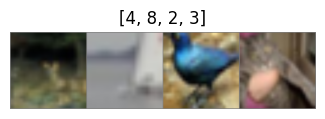

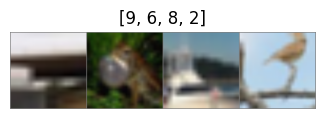

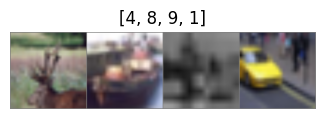

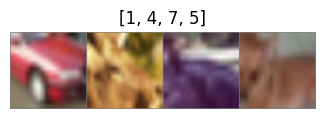

In [ ]:
for i in range(4):
    batch_img_show(trainloader)

# **VGG-16**

In [ ]:
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])   # changing the classifier to classify only 10 classes instead of 1000
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# **Training VGG**

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
def evaluation(dataloader, model):
    total , correct = 0,0
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, pred = torch.max(outputs.data, 1)
      correct += (pred == labels).sum().item()
      total += labels.size(0)
    return 100 * correct/ total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

In [ ]:
loss_epoch = []
epochs = 1
n_ter = np.ceil(50000/ batch_size)
for epoch in range(epochs):
    for i , data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        del inputs, outputs, labels
        torch.cuda.empty_cache()
        if (i % 100 == 0):
            print('Iteration: %d/%d, Loss: %f' % (i, n_ter, loss.item()))
    loss_epoch.append(loss.item())
    print("Epoch: %d/%d, Train acc: %f, Test acc: %f" % (epoch, epochs, evaluation(train_loader, vgg), evaluation(testloader, vgg)))
plt.plot(loss_epoch)
plt.show()

Iteration: 0/3125, Loss: 67.581589
Iteration: 100/3125, Loss: 2.183341
Iteration: 200/3125, Loss: 2.227987
Iteration: 300/3125, Loss: 2.317949
Iteration: 400/3125, Loss: 2.309816
Iteration: 500/3125, Loss: 2.315697
Iteration: 600/3125, Loss: 2.361920
Iteration: 700/3125, Loss: 2.325511
Iteration: 800/3125, Loss: 2.346829
Iteration: 900/3125, Loss: 2.275772
Iteration: 1000/3125, Loss: 2.210587
Iteration: 1100/3125, Loss: 2.305868
Iteration: 1200/3125, Loss: 2.342130
Iteration: 1300/3125, Loss: 2.405045
Iteration: 1400/3125, Loss: 2.257510
Iteration: 1500/3125, Loss: 2.253652
Iteration: 1600/3125, Loss: 2.372052
Iteration: 1700/3125, Loss: 2.334403
Iteration: 1800/3125, Loss: 2.274646
Iteration: 1900/3125, Loss: 2.406592
Iteration: 2000/3125, Loss: 2.327592
Iteration: 2100/3125, Loss: 2.266474
Iteration: 2200/3125, Loss: 2.297319
Iteration: 2300/3125, Loss: 2.317391
Iteration: 2400/3125, Loss: 2.264807
Iteration: 2500/3125, Loss: 2.281828
Iteration: 2600/3125, Loss: 2.339152
Iteration: 2

KeyboardInterrupt: ignored

In [ ]:
# Even for 1 epochs the training takes so much time, that means the model has ionly seen the all the images only for once.
# To speed up the traing we use transfer leaning by freezing the convolution layers.

# **Freeze layers of Convolution**

In [ ]:
vgg = models.vgg16_bn(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 70.3MB/s]


In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

In [ ]:
loss_epoch = []
epochs = 1
n_iter = np.ceil(50000/batch_size)
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        del outputs, inputs, labels
        torch.cuda.empty_cache()
        if (i %100 == 0):
            print("Iteration: %d/%d, Loss: %f"% (i, n_iter, loss.item()))
    loss_epoch.append(loss.item())
    print("Epoch: %d/%d, Test acc : %f, Train acc: %f", (epoch, epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))
plt.plot(loss_epoch)
plt.show()

Iteration: 0/3125, Loss: 2.301475
Iteration: 100/3125, Loss: 1.116136
Iteration: 200/3125, Loss: 6.841043
Iteration: 300/3125, Loss: 2.705373
Iteration: 400/3125, Loss: 6.731321
Iteration: 500/3125, Loss: 5.123198
Iteration: 600/3125, Loss: 2.316979
Iteration: 700/3125, Loss: 7.238139
Iteration: 800/3125, Loss: 4.013293
Iteration: 900/3125, Loss: 9.275551


KeyboardInterrupt: ignored

In [ ]:
evaluation(testloader, vgg)

32.18

In [ ]:
# While training the loss fluctuates, the reason may be that it is oscillating on the minima

# **With Model Copies**

In [ ]:
import copy

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
loss_epoch = []
min_loss = 1000
epochs = 1
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print("MIN loss %f" % min_loss)
        if i%100 == 0:
            print("Iteration: %d/%d, Loss: %f "% (i, n_iter, loss.item()))
        del inputs, outputs, labels
        torch.cuda.empty_cache()
    loss_epoch.append(loss.item())

MIN loss 4.009845
Iteration: 0/3125, Loss: 4.009845 
MIN loss 3.547508
MIN loss 3.098563
MIN loss 2.904542
MIN loss 2.739578
MIN loss 2.429369
MIN loss 2.371636
MIN loss 2.158121
MIN loss 1.489576
MIN loss 1.462674
Iteration: 100/3125, Loss: 3.447562 
MIN loss 0.989497
Iteration: 200/3125, Loss: 3.454746 
Iteration: 300/3125, Loss: 3.005029 
Iteration: 400/3125, Loss: 3.211447 
MIN loss 0.881552
Iteration: 500/3125, Loss: 3.612951 
MIN loss 0.741774
Iteration: 600/3125, Loss: 2.314277 
Iteration: 700/3125, Loss: 3.312689 
Iteration: 800/3125, Loss: 2.928297 
Iteration: 900/3125, Loss: 4.145133 
Iteration: 1000/3125, Loss: 3.432920 
Iteration: 1100/3125, Loss: 4.150126 
Iteration: 1200/3125, Loss: 3.657947 
Iteration: 1300/3125, Loss: 2.578800 
Iteration: 1400/3125, Loss: 2.295744 
MIN loss 0.698763
Iteration: 1500/3125, Loss: 2.066407 
MIN loss 0.691000
Iteration: 1600/3125, Loss: 1.739592 
Iteration: 1700/3125, Loss: 2.704758 
Iteration: 1800/3125, Loss: 2.087079 
Iteration: 1900/3125

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

43.184 36.46


# **ResNet Model**

In [ ]:
resnet = models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad == True:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr = 0.01)

MIN loss :  2.1622211933135986
Iteration 0/3125, loss:2.162221
MIN loss :  2.0731654167175293
MIN loss :  2.055983066558838
MIN loss :  2.0286641120910645
MIN loss :  2.0017430782318115
MIN loss :  1.9842822551727295
MIN loss :  1.9695515632629395
MIN loss :  1.95384681224823
MIN loss :  1.9350647926330566
MIN loss :  1.8896400928497314
MIN loss :  1.8782724142074585
MIN loss :  1.8153287172317505
MIN loss :  1.7166082859039307
MIN loss :  1.6950089931488037
MIN loss :  1.5705287456512451
MIN loss :  1.4650055170059204
Iteration 100/3125, loss:1.465006
MIN loss :  1.4450474977493286
MIN loss :  1.424384355545044
MIN loss :  1.2651445865631104
MIN loss :  1.2504959106445312
MIN loss :  1.0629386901855469
Iteration 200/3125, loss:1.610057
Iteration 300/3125, loss:1.315788
MIN loss :  0.8945938944816589
Iteration 400/3125, loss:1.318204
MIN loss :  0.8806944489479065
Iteration 500/3125, loss:1.420534
Iteration 600/3125, loss:1.461617
MIN loss :  0.8555507659912109
MIN loss :  0.8320854902

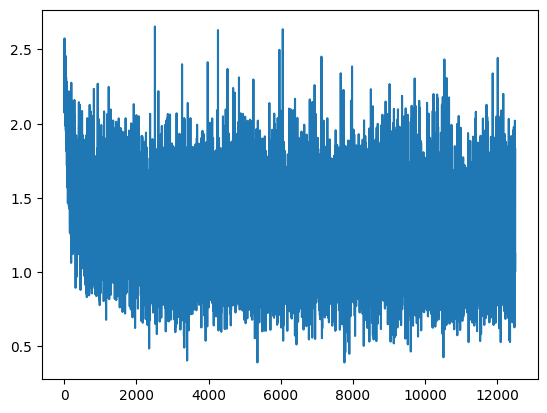

In [ ]:
loss_epoch = []
epochs = 4
min_loss = 1000
for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs , labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print("MIN loss : ",min_loss)
        if i%100 == 0:
            print("Iteration %d/%d, loss:%f" % (i, n_iter, loss.item()))
        del inputs, outputs, labels
        torch.cuda.empty_cache()
        loss_epoch.append(loss.item())
    print("Epoch %d/%d, Train acc: %f, Test acc: %f" % (epoch, epochs, evaluation(trainloader, resnet), evaluation(testloader, resnet)))
plt.plot(loss_epoch)
plt.show()

In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

57.738 47.35


# **Inception Model**

In [ ]:
inception = models.inception_v3(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 22.9MB/s]


In [ ]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
                                     )
transform_test = transforms.Compose([transforms.RandomResizedCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
                                    )

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = "./data", download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = ".data", download = True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.01)

In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return 100 * correct / total

Min loss 1.837304
Iteration: 0/3125, loss: 1.837304
Min loss 1.461982
Min loss 1.450483
Min loss 1.392153
Min loss 1.362663
Min loss 1.315722
Iteration: 100/3125, loss: 2.440435
Min loss 1.114643
Iteration: 200/3125, loss: 1.520149
Min loss 1.026052
Iteration: 300/3125, loss: 1.845636
Iteration: 400/3125, loss: 1.642253
Iteration: 500/3125, loss: 1.896719
Iteration: 600/3125, loss: 2.141198
Iteration: 700/3125, loss: 1.653142
Iteration: 800/3125, loss: 1.848127
Min loss 0.968111
Iteration: 900/3125, loss: 1.375285
Iteration: 1000/3125, loss: 1.793505
Iteration: 1100/3125, loss: 1.293716
Iteration: 1200/3125, loss: 1.507419
Iteration: 1300/3125, loss: 2.429767
Iteration: 1400/3125, loss: 2.425950
Iteration: 1500/3125, loss: 1.548130
Iteration: 1600/3125, loss: 2.464082
Min loss 0.910468
Iteration: 1700/3125, loss: 1.679670
Min loss 0.854487
Iteration: 1800/3125, loss: 2.141707
Iteration: 1900/3125, loss: 1.877909
Iteration: 2000/3125, loss: 2.703637
Iteration: 2100/3125, loss: 1.652458


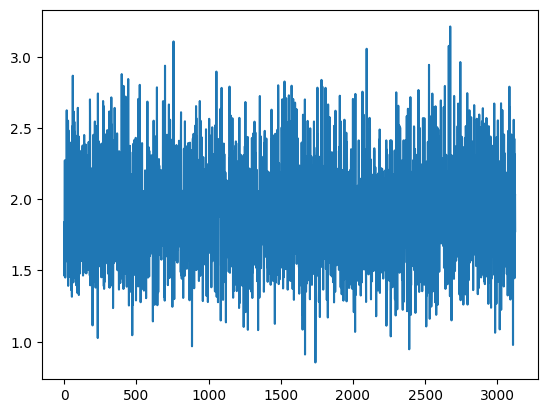

In [ ]:
loss_epoch = []
epochs = 1
min_loss = 1000
for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs , aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        if min_loss >loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print("Min loss %f" % min_loss)
        if i % 100 == 0:
            print("Iteration: %d/%d, loss: %f" % (i, n_iter, loss.item()))
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        loss_epoch.append(loss.item())
    print("Epoch: %d/%d, Test acc: %f, Train acc: %f", epoch, epochs,
          evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception))
plt.plot(loss_epoch)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.45 47.388
